In [1]:
import torch
from torch.nn import Sequential, Linear, ReLU, Softmax
import numpy as np
import json
import socket
from time import time
import os
os.system("pip install matplotlib")
import matplotlib.pyplot as plt

In [2]:
"""
Simple Neural Net
Initially, input is features, output is action
"""
FEATURE_NUM = 14
ACTION_NUM = 10


class ActorCritic:
    def __init__(self):                 

        self.device = torch.device("cuda")

        actor_size = 128
        self.actor = Sequential(
            # feature size by hidden size
            Linear(FEATURE_NUM, actor_size),
            ReLU(),
            # Linear(actor_size, actor_size),
            # ReLU(),
            # hidden size by action size
            Linear(actor_size, ACTION_NUM),
            Softmax(dim=-1)
        ).to(self.device)

        critic_size = 32
        self.critic = Sequential(
            # feature size by hidden size
            Linear(FEATURE_NUM, critic_size),
            ReLU(),
            Linear(critic_size, critic_size),
            ReLU(),
            # hidden size by action size
            Linear(critic_size, 1),
        ).to(self.device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=2e-3)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=5e-4)
        self.gamma = 0.996
        self.num_backward = 0
        self.total_steps = 0
        self.total_reward = 0
        self.ep_steps = 0
        self.total_loss = [0,0]

        self.ep_count = 0
        self.plt_x = []
        self.plt_y = []

        # If weights already exist, load them
        if os.path.exists("critic_pretrained_weights.pt"):
            self.critic.load_state_dict(torch.load("critic_pretrained_weights.pt", map_location="cuda:0"))
        if os.path.exists("actor_pretrained_weights.pt"):
            self.actor.load_state_dict(torch.load("actor_pretrained_weights.pt", map_location="cuda:0"))

        self.reset()

    def reset(self):
        self.ep_count += 1
        print("COMPLETED EPISODE IN " + str(self.ep_steps) + " STEPS!")
        print("TOTAL REWARD: " + str(self.total_reward))
        print("TOTAL LOSS (ACTOR, CRITIC): " + str(self.total_loss))
        self.plt_x = np.append(self.plt_x, self.ep_count)
        self.plt_y = np.append(self.plt_y, self.ep_steps)

        self.ep_steps = 0
        self.total_reward = 0
        self.total_loss = [0,0]
        self.state = None
        self.reward = None
        self.action = None


    def forward(self, input_feats):
        # Take as input a featurized state, output action probs
        probs = self.actor(input_feats.to(self.device))
        # Randomly select action according to probs
        return probs
    
    def value(self, input_feats):
        value = self.critic(input_feats.to(self.device))
        return value
    
    def get_action(self, input_feats):
        # samples an action from the softmax distribution
        self.total_steps += 1
        self.ep_steps += 1
        probs = self.forward(input_feats)
        action = np.random.choice(probs.shape[0], p=probs.cpu().detach().numpy())
        # action = int(np.argmax(probs.cpu().detach().numpy())) # Deterministic
        self.state = input_feats
        self.action = action
        return action
    
    def loss(self, next_state):

        action_probs = self.forward(self.state)

        cur_value = self.value(self.state)
        next_value = self.value(next_state)

        advantage = self.reward + self.gamma*next_value - cur_value
        # print("Reward: " + str(self.reward) + "  ///  next_value: " + str(next_value) + "  ///  cur_value: " + str(cur_value))
        
        advantage_copy = advantage.clone()
        # actor_loss = torch.abs(advantage * torch.log(action_probs[self.action]))
        actor_loss = -advantage * torch.log(action_probs[self.action]) # ORIGINAL
        # print("Log Probs: " + str(torch.log(action_probs[self.action])))
        # critic_loss = -advantage_copy
        critic_loss = torch.square(advantage_copy) # ORIGINAL

        self.total_loss[0] = self.total_loss[0] + actor_loss.tolist()[0] 
        self.total_loss[1] = self.total_loss[1] + critic_loss.tolist()[0]

        return (actor_loss, critic_loss)

    def backward(self, next_state):
        # Ignore if websocket returned for no reason
        # Might need both current and previous state
        # Terminal, don't want to do a backward pass on next
        self.num_backward += 1

        actor_loss, critic_loss = self.loss(next_state)

        if self.reward != None:
            if self.total_reward != None:
                self.total_reward += self.reward
            else:
                self.total_reward = self.reward
        
        # loss = actor_loss + critic_loss # might cause errors

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor_optimizer.step()

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Every 10 backward passes, save the model
        if self.num_backward % 5 == 0:
            # print(f"Saving model. Num total steps={self.total_steps}. Num backward passes={self.num_backward}")
            # print(f"Total rewards: " + str(self.total_reward))
            # print(f"Current Reward: " + str(self.reward))
            start = time()
            torch.save(self.actor.state_dict(), "actor_pretrained_weights.pt")
            torch.save(self.critic.state_dict(), "critic_pretrained_weights.pt")
        return 0

    def discounted_return(self, rewards):
        return np.dot(self.gamma ** np.arange(len(rewards)), rewards)

In [3]:
# Handle json

def convert_to_feats(response_dict):
    """Takes a response dictionary and returns tensor of features"""
    return torch.Tensor(
        (
            response_dict['feat1'],
            response_dict['feat2'],
            response_dict['feat3'],
            response_dict['feat4'],
            response_dict['feat5'],
            response_dict['feat6'],
            response_dict['feat7'],
            response_dict['feat8'],
            response_dict['feat9'],
            response_dict['feat10'],
            response_dict['feat11'],
            response_dict['feat12'],
            response_dict['feat13'],
            response_dict['feat14'],
        )
    )

def handle_response(response, net: ActorCritic):
    """Take as input a websocket response from C#, return serialized data to send back"""
    # Initialize response
    instruction = ''
    action = 0
    if response is None:
        print("Response none")
        return {}
    response_dict = json.loads(response)

    # Store the reward for the previous action. 
    # Don't worry about the first one in the array, it will be ignored
    net.reward = response_dict['reward']

    # Handle forward pass
    if response_dict['instruction'] == 'forward':
        features = convert_to_feats(response_dict)
        if net.state != None:
            net.backward(features)
        action = net.get_action(features)
        instruction = 'step'
    elif response_dict['instruction'] == 'update_weights':
        instruction = 'reset'

        features = convert_to_feats(response_dict)
        net.backward(features)
        net.reset()
        # print(f"Took {time() - start:.4f} seconds to compute backward pass")        

    json_return_dict = {
        'instruction': instruction,
        'action': action,
    }
    
    return json_return_dict

## TODO
# Video of training randomly and video of training close to final value
# Throw in graph of number of steps (maybe)

COMPLETED EPISODE IN 0 STEPS!
TOTAL REWARD: 0
TOTAL LOSS (ACTOR, CRITIC): [0, 0]
COMPLETED EPISODE IN 212 STEPS!
TOTAL REWARD: 179.84919694066048
TOTAL LOSS (ACTOR, CRITIC): [610.8554397821426, 90057.85641998053]
COMPLETED EPISODE IN 829 STEPS!
TOTAL REWARD: -245.20563977956772
TOTAL LOSS (ACTOR, CRITIC): [-515.1316367089748, 90356.05118850619]
COMPLETED EPISODE IN 193 STEPS!
TOTAL REWARD: 166.058883279562
TOTAL LOSS (ACTOR, CRITIC): [372.3747532069683, 90024.26972728223]
COMPLETED EPISODE IN 419 STEPS!
TOTAL REWARD: 12.265356421470642
TOTAL LOSS (ACTOR, CRITIC): [408.85425493121147, 90114.45785903558]
COMPLETED EPISODE IN 589 STEPS!
TOTAL REWARD: -177.396031498909
TOTAL LOSS (ACTOR, CRITIC): [-283.02859775722027, 90257.40947475657]
COMPLETED EPISODE IN 17 STEPS!
TOTAL REWARD: 291.9636830687523
TOTAL LOSS (ACTOR, CRITIC): [98.22333893924952, 89780.27915591747]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [27.34960193745792, 89696.513394124

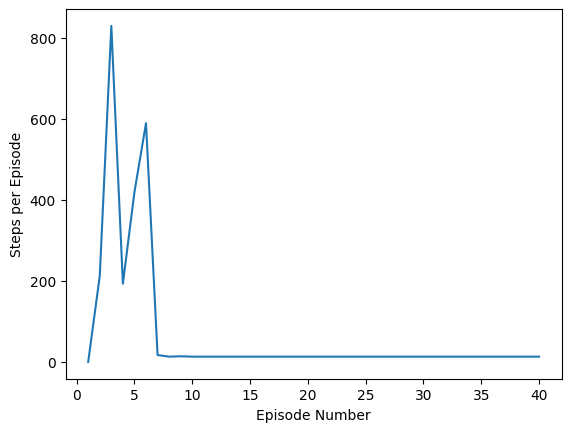

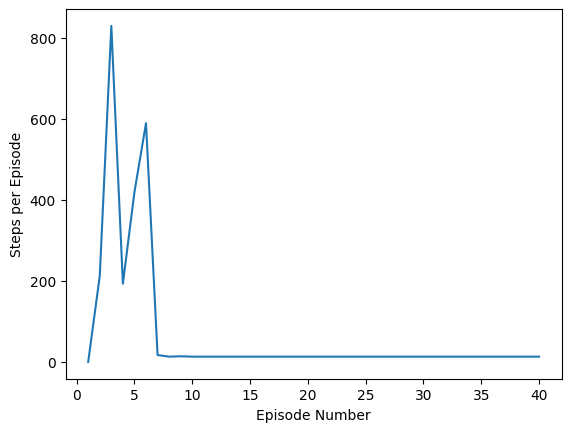

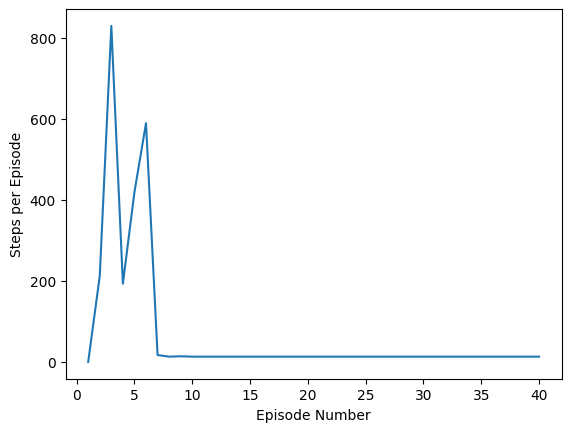

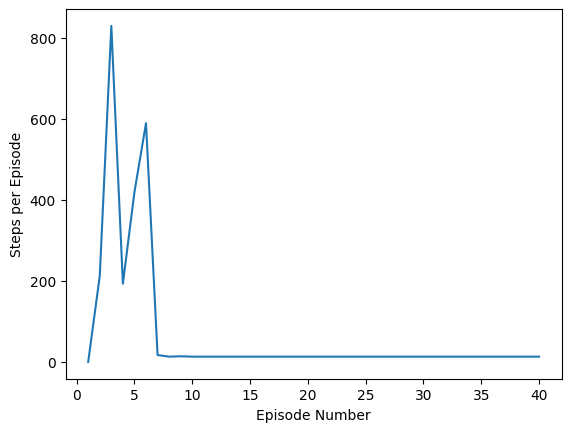

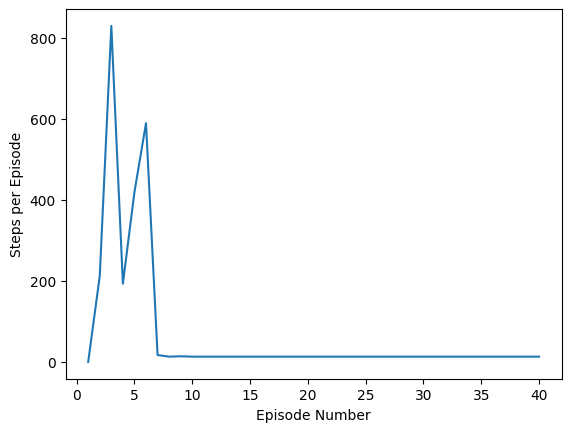

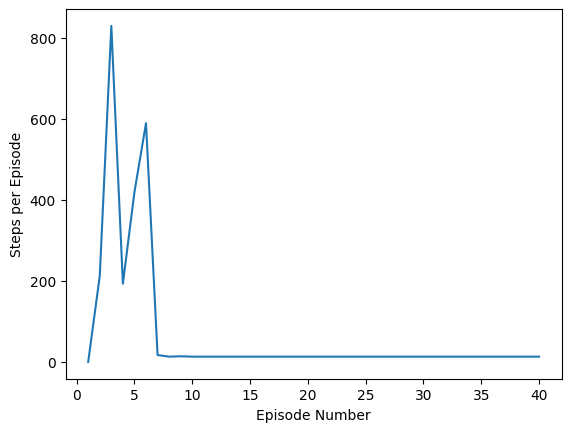

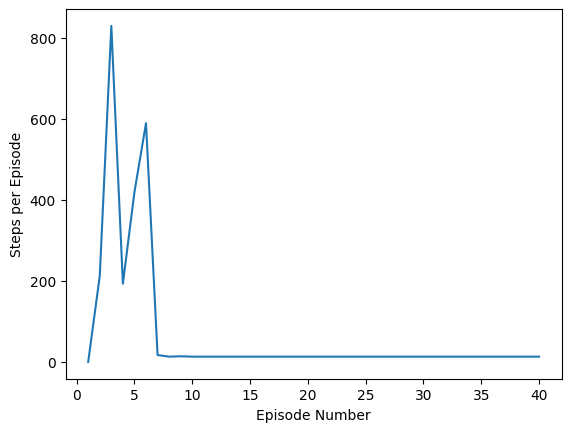

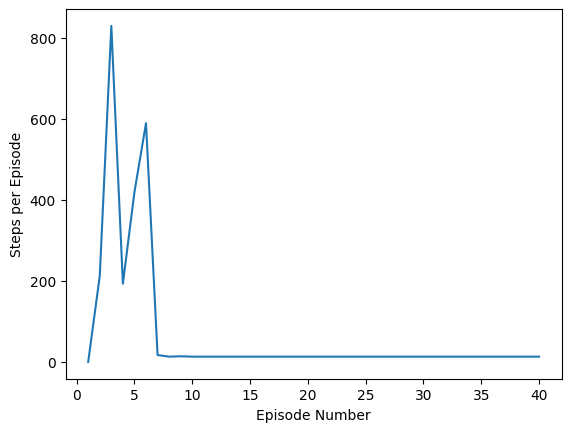

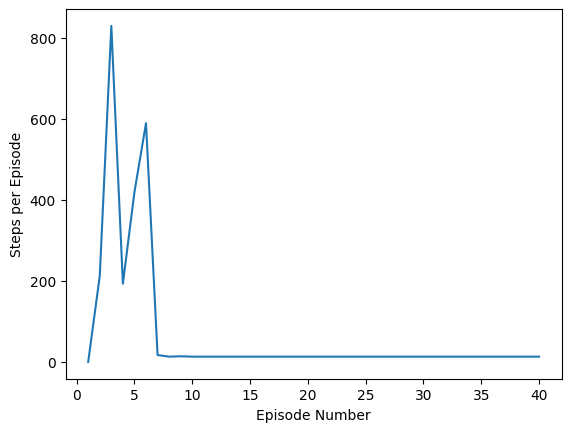

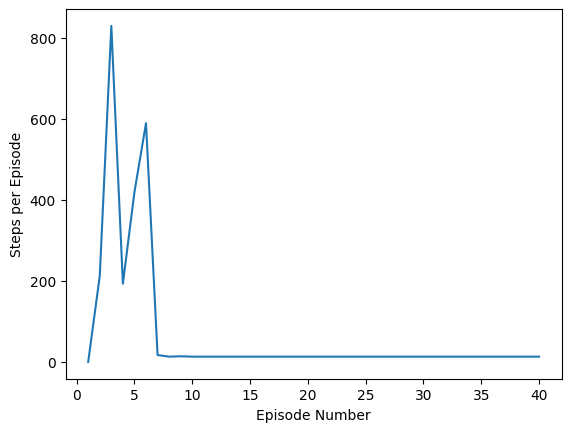

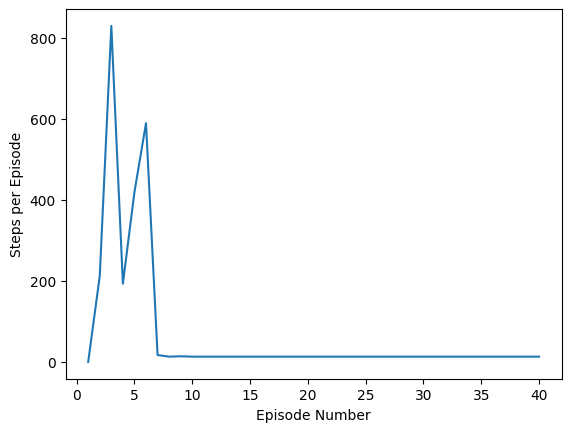

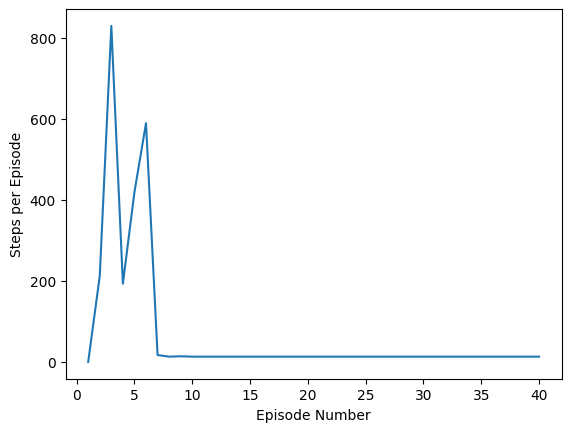

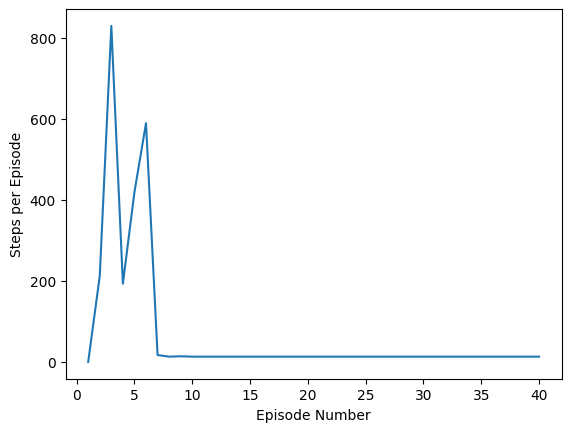

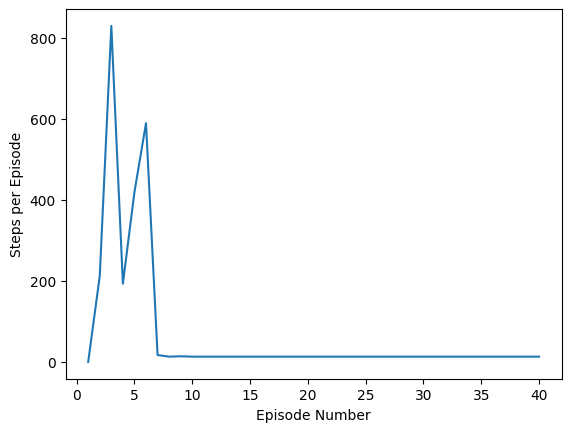

COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.49562800065177726, 84154.76071296632]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.476404902547074, 83877.42716668546]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.4589227930191555, 83633.22735588253]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.44232098152133403, 83364.86845555902]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.4267277414473938, 83097.06631338596]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.4117665582962218, 82862.41643840075]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS (ACTOR, CRITIC): [0.3981233683953178, 82686.35466843843]
COMPLETED EPISODE IN 13 STEPS!
TOTAL REWARD: 294.17528861761093
TOTAL LOSS 

KeyboardInterrupt: 

In [4]:
host, port = "127.0.0.1", 25001

# SOCK_STREAM means TCP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

neural_net = ActorCritic()
request = {
    'instruction': 'init',
    'action': 0,
}

def on_receive(message):
    print(message)

try:
    # Connect to the server and send the data
    sock.connect((host, port))

    start = 0

    from time import time

    while(True):
        # print(request)
        request = json.dumps(request)
        sock.sendall(request.encode("utf-8"))
        response = sock.recv(1024).decode("utf-8")
        # print(f"Took {time() - start:.4f} between, that's {1/(time() - start):.2f} Hz")
        start = time()
        request = handle_response(response, neural_net)

        if neural_net.ep_count == 40:
            plt.plot(neural_net.plt_x, neural_net.plt_y)
            plt.xlabel("Episode Number")
            plt.ylabel("Steps per Episode")
            
            plt.savefig("actor_critic_plot.png")
            plt.show()
finally:
    sock.close()